#### Environment

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import time

from typing import Iterable, Tuple
from dataclasses import dataclass

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms

#### Architecture of LeNet5


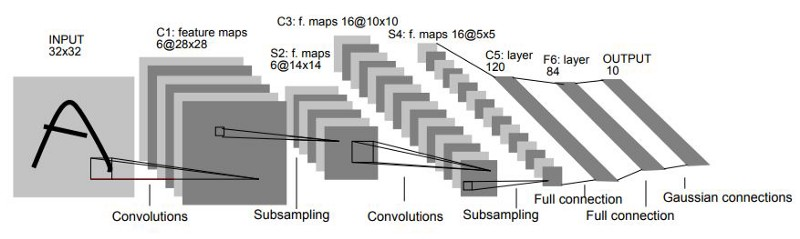

In [ ]:
from torch.nn.modules.conv import Conv2d
from torch.nn.modules.pooling import MaxPool2d
class LeNet5(nn.Module):
  def __init__(self):
    super().__init__()
    # Convolution layers
    self._body = nn.Sequential(
        nn.Conv2d(in_channels=1,out_channels=6, kernel_size=5),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2),

        nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(kernel_size=2),
    )
    # Fully connected layers
    self._head = nn.Sequential(
        nn.Linear(in_features=16*5*5,out_features=120),
        nn.ReLU(inplace=True),
        nn.Linear(in_features=120,out_features=84),
        nn.ReLU(inplace=True),
        nn.Linear(in_features=84,out_features=10),
    )

  def forward(self,x):
    x = self._body(x)
    x = x.view(x.size()[0],-1)
    x = self._head(x)
    return x

In [ ]:
lenet5_model = LeNet5()
print(lenet5_model)

LeNet5(
  (_body): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (_head): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)


#### Prepare data

* dataloader: iterator that create batch data, transform data when required.
* What we need to do here with the img data:<br>
  (1) resize img to 32*32 - transform.resize <br>
  (2) Rescale the values of pixels from 0-255 to 0-1 - transforms.ToTensor<br>
  (3) Normalize data. - transform.Normalize<br>

In [ ]:
def get_data(batch_size, data_root='data', num_workers=1):
    
    train_test_transforms = transforms.Compose([
        transforms.Resize((32, 32)),    
        transforms.ToTensor(),
        transforms.Normalize((0.1307, ), (0.3081, ))
    ])
    
    # train dataloader
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST(root=data_root, train=True, download=True, transform=train_test_transforms),
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers
    )
    
    # test dataloader
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST(root=data_root, train=False, download=True, transform=train_test_transforms),
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )
    return train_loader, test_loader

#### Configuration & system setup

In [ ]:
@dataclass
class SystemConfiguration:
    '''
    Describes the common system setting needed for reproducible training
    '''
    seed: int = 0  
    cudnn_benchmark_enabled: bool = True  
    cudnn_deterministic: bool = True  

@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 32  
    epochs_count: int = 20 
    learning_rate: float = 0.01 
    log_interval: int = 100  
    test_interval: int = 1 
    data_root: str = "data"  
    num_workers: int = 10  
    device: str = 'cuda'  
def setup_system(system_config: SystemConfiguration) -> None:
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic

In [ ]:
# system & training configuration   
system_configuration=SystemConfiguration()
setup_system(system_configuration)
training_configuration=TrainingConfiguration()


batch_size_to_set = training_configuration.batch_size
num_workers_to_set = training_configuration.num_workers
epoch_num_to_set = training_configuration.epochs_count

# if GPU is available use training config, else lower batch_size, num_workers and epochs count
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
    batch_size_to_set = 16
    num_workers_to_set = 2
    epoch_num_to_set = 5
train_loader, test_loader = get_data(
    batch_size=batch_size_to_set,
    data_root=training_configuration.data_root,
    num_workers=num_workers_to_set
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


#### Training process 

In [ ]:
def train(
    train_config: TrainingConfiguration, model: nn.Module, optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader, epoch_idx: int
) -> Tuple[float, float]:
    
    # change model in training mode
    model.train()
    

    batch_loss = np.array([])
    batch_acc = np.array([])
        
    for batch_idx, (data, target) in enumerate(train_loader):
        
        indx_target = target.clone()
        data = data.to(train_config.device)
        target = target.to(train_config.device)

        optimizer.zero_grad()

        output = model(data)
        
        loss = F.cross_entropy(output, target)
        
        loss.backward()
        optimizer.step()
        
        batch_loss = np.append(batch_loss, [loss.item()])
        
        prob = F.softmax(output, dim=1)

        pred = prob.data.max(dim=1)[1]  
                        
        # correct prediction
        correct = pred.cpu().eq(indx_target).sum()
            
        # accuracy
        acc = float(correct) / float(len(data))
        
        batch_acc = np.append(batch_acc, [acc])

        if batch_idx % train_config.log_interval == 0 and batch_idx > 0:              
            print(
                'Train Epoch: {} [{}/{}] Loss: {:.6f} Acc: {:.4f}'.format(
                    epoch_idx, batch_idx * len(data), len(train_loader.dataset), loss.item(), acc
                )
            )
            
    epoch_loss = batch_loss.mean()
    epoch_acc = batch_acc.mean()
    return epoch_loss, epoch_acc

#### Validation process

In [ ]:
def validate(
    train_config: TrainingConfiguration,
    model: nn.Module,
    test_loader: torch.utils.data.DataLoader,
) -> Tuple[float, float]:
    model.eval()
    test_loss = 0
    count_corect_predictions = 0
    
    # turn off gradient-computation
    with torch.no_grad():
        
        for data, target in test_loader:
            indx_target = target.clone()
            data = data.to(train_config.device)

            target = target.to(train_config.device)

            output = model(data)
            test_loss += F.cross_entropy(output, target).item()
            prob = F.softmax(output, dim=1)
            pred = prob.data.max(dim=1)[1] 

            count_corect_predictions += pred.cpu().eq(indx_target).sum()

        test_loss = test_loss / len(test_loader)  

        accuracy = 100. * count_corect_predictions / len(test_loader.dataset)

        print(
            '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
                test_loss, count_corect_predictions, len(test_loader.dataset), accuracy
            )
        )
    return test_loss, accuracy/100.0

#### Main processor

In [ ]:
def main(system_configuration=SystemConfiguration(), training_configuration=TrainingConfiguration()):
    
    # system configuration
    setup_system(system_configuration)


    batch_size_to_set = training_configuration.batch_size
    num_workers_to_set = training_configuration.num_workers
    epoch_num_to_set = training_configuration.epochs_count

    # if GPU is available use training config, else lower batch_size, num_workers and epochs count
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
        batch_size_to_set = 16
        num_workers_to_set = 2
        epoch_num_to_set = 5

    # data loader
    train_loader, test_loader = get_data(
        batch_size=batch_size_to_set,
        data_root=training_configuration.data_root,
        num_workers=num_workers_to_set
    )
    
    # Update training configuration
    training_configuration = TrainingConfiguration(
        device=device,
        epochs_count=epoch_num_to_set,
        batch_size=batch_size_to_set,
        num_workers=num_workers_to_set
    )

    # initiate model
    model = LeNet5()
        
    # send model to device (GPU/CPU)
    model.to(training_configuration.device)

    # optimizer
    optimizer = optim.SGD(
        model.parameters(),
        lr=training_configuration.learning_rate
    )

    best_loss = torch.tensor(np.inf)
    
    # epoch train/test loss
    epoch_train_loss = np.array([])
    epoch_test_loss = np.array([])
    
    # epoch train/test accuracy
    epoch_train_acc = np.array([])
    epoch_test_acc = np.array([])
    
    # training time measurement
    t_begin = time.time()
    for epoch in range(training_configuration.epochs_count):
        
        train_loss, train_acc = train(training_configuration, model, optimizer, train_loader, epoch)
        
        epoch_train_loss = np.append(epoch_train_loss, [train_loss])
        
        epoch_train_acc = np.append(epoch_train_acc, [train_acc])

        elapsed_time = time.time() - t_begin
        speed_epoch = elapsed_time / (epoch + 1)
        speed_batch = speed_epoch / len(train_loader)
        eta = speed_epoch * training_configuration.epochs_count - elapsed_time
        
        print(
            "Elapsed {:.2f}s, {:.2f} s/epoch, {:.2f} s/batch, ets {:.2f}s".format(
                elapsed_time, speed_epoch, speed_batch, eta
            )
        )

        if epoch % training_configuration.test_interval == 0:
            current_loss, current_accuracy = validate(training_configuration, model, test_loader)
            
            epoch_test_loss = np.append(epoch_test_loss, [current_loss])
        
            epoch_test_acc = np.append(epoch_test_acc, [current_accuracy])
            
            if current_loss < best_loss:
                best_loss = current_loss
                
    print("Total time: {:.2f}, Best Loss: {:.3f}".format(time.time() - t_begin, best_loss))
    
    return model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc

In [ ]:
model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc = main()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train Epoch: 0 [3200/60000] Loss: 2.263768 Acc: 0.3125
Train Epoch: 0 [6400/60000] Loss: 2.063268 Acc: 0.5312
Train Epoch: 0 [9600/60000] Loss: 0.767509 Acc: 0.7500
Train Epoch: 0 [12800/60000] Loss: 0.354854 Acc: 0.8750
Train Epoch: 0 [16000/60000] Loss: 0.391466 Acc: 0.8750
Train Epoch: 0 [19200/60000] Loss: 0.393752 Acc: 0.8438
Train Epoch: 0 [22400/60000] Loss: 0.468851 Acc: 0.8438
Train Epoch: 0 [25600/60000] Loss: 0.330662 Acc: 0.9062
Train Epoch: 0 [28800/60000] Loss: 0.201630 Acc: 0.9062
Train Epoch: 0 [32000/60000] Loss: 0.194850 Acc: 0.9688
Train Epoch: 0 [35200/60000] Loss: 0.130745 Acc: 0.9688
Train Epoch: 0 [38400/60000] Loss: 0.266731 Acc: 0.9375
Train Epoch: 0 [41600/60000] Loss: 0.106055 Acc: 0.9375
Train Epoch: 0 [44800/60000] Loss: 0.423160 Acc: 0.9062
Train Epoch: 0 [48000/60000] Loss: 0.068140 Acc: 0.9688
Train Epoch: 0 [51200/60000] Loss: 0.071323 Acc: 0.9688
Train Epoch: 0 [54400/60000] Loss: 0.089922 Acc: 0.9688
Train Epoch: 0 [57600/60000] Loss: 0.116218 Acc: 0.

#### Show result

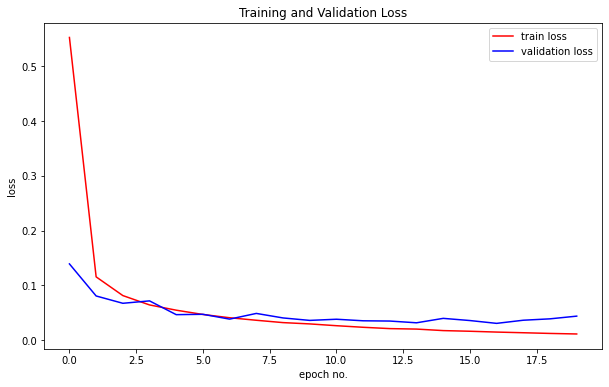

In [ ]:
plt.rcParams["figure.figsize"] = (10, 6)
x = range(len(epoch_train_loss))


plt.figure
plt.plot(x, epoch_train_loss, color='r', label="train loss")
plt.plot(x, epoch_test_loss, color='b', label="validation loss")
plt.xlabel('epoch no.')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

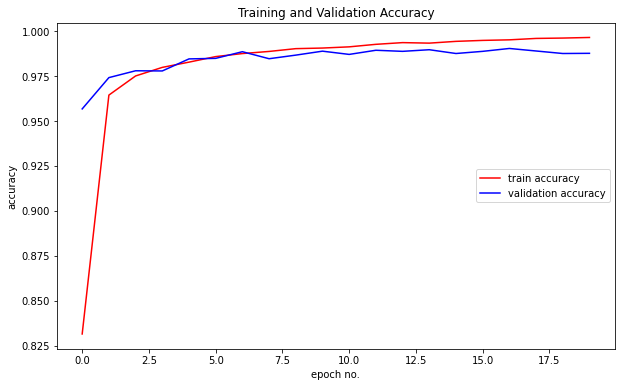

In [ ]:
plt.rcParams["figure.figsize"] = (10, 6)
x = range(len(epoch_train_loss))


plt.figure
plt.plot(x, epoch_train_acc, color='r', label="train accuracy")
plt.plot(x, epoch_test_acc, color='b', label="validation accuracy")
plt.xlabel('epoch no.')
plt.ylabel('accuracy')
plt.legend(loc='center right')
plt.title('Training and Validation Accuracy')
plt.show()

#### Save and prediction

In [ ]:
models = 'models'
if not os.path.exists(models):
    os.makedirs(models)
    
model_file_name = 'lenet5_mnist.pt'

model_path = os.path.join(models, model_file_name)

# transfer the model to cpu.
model.to('cpu')

# save the state_dict
torch.save(model.state_dict(), model_path)

In [ ]:
lenet5_mnist = LeNet5()
lenet5_mnist.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
def prediction(model, train_config, batch_input):
    
    # turn off gradient-computation
    with torch.no_grad():
    
        model.to(train_config.device)
        model.eval()

        data = batch_input.to(train_config.device)

        output = model(data)

        prob = F.softmax(output, dim=1)

        pred_prob = prob.data.max(dim=1)[0]

        pred_index = prob.data.max(dim=1)[1]
    
    return pred_index.cpu().numpy(), pred_prob.cpu().numpy()

#### Example

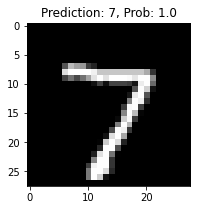

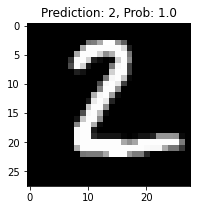

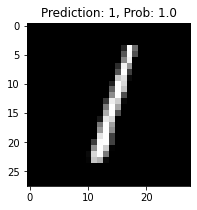

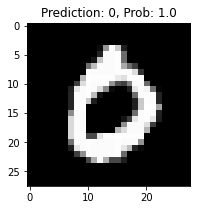

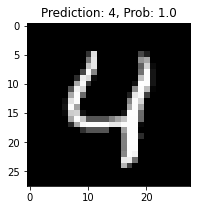

In [ ]:
batch_size = 5
train_config = TrainingConfiguration()

if torch.cuda.is_available():
    train_config.device = "cuda"
else:
    train_config.device = "cpu"

test = torch.utils.data.DataLoader(
    datasets.MNIST(root=train_config.data_root, train=False, download=True, 
                   transform=transforms.functional.to_tensor),
    batch_size=batch_size,
    shuffle=False,
    num_workers=1
    )

image_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307, ), (0.3081, ))
    ])

test_trans = torch.utils.data.DataLoader(
    datasets.MNIST(root=train_config.data_root, train=False, download=True, transform=image_transforms),
    batch_size=batch_size,
    shuffle=False,
    num_workers=1
    )

for data, _ in test_trans:
    # pass the loaded model
    pred, prob = prediction(lenet5_mnist, train_config, data)
    break
    

plt.rcParams["figure.figsize"] = (3, 3)
for images, _ in test:
    for i, img in enumerate(images):
        img = transforms.functional.to_pil_image(img)
        plt.imshow(img, cmap='gray')
        plt.gca().set_title('Prediction: {0}, Prob: {1:.2}'.format(pred[i], prob[i]))
        plt.show()
    break